## Introduction

To recap from project 1, we are using the 'flights' data set, as found on Kaggle. Our main interest is predicting the arrival delay of flights. In this round of analysis, we are interested in predicting arrival delays exceeding fifteen minutes. We hypothesize we will take our classification efforts further in the next project to arrive at an ordinal prediction. For now, we are focused on the variable ARRIVAL_IND, which represents the arrival indicator of 0=not delayed at arrival and 1=delayed at arrival.

## Create Models: Logistic Regression and SVM

<span style="color:blue; font-size:1.25em;">  Data Import and Cleaning </span>

Project 1's exploratory data analysis led us to believe that delays vary by region and airline. Instead of modeling all U.S. flights, we will focus our efforts on predicting flights leaving Atlanta's Hartsfield-Jackson Airport. We chose this airport for analysis because it is the busiest in the country. Our business objective remains to create an accurate model with high accuracy and low false negatives to allow the flying public to project the flight status of their specific flight ahead of time. 


In [1]:
#data import and cleaning
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
df1 = pd.read_csv('rawdata.csv',low_memory=False, encoding = 'ISO-8859-1')
df1 = df1.drop(['ARRIVAL_DELAY', 'DEPARTURE_IND', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'CANCELLATION_REASON', 'YEAR',
                'Unnamed: 0','DATE', 'AIRLINE', 'DESTINATION_LONGITUDE', 'DESTINATION_LATITUDE', 'DESTINATION_AIRPORT_NAME',
                'DEPARTING_LONGITUDE','DEPARTING_LATITUDE','DEPARTING_AIRPORT_ NAME', 'CANCELLED', 'DIVERTED', 'TAIL_NUMBER',
                'FLIGHT_NUMBER','DEPARTING_CITY','DEPARTING_STATE', 'DEPARTING_COUNTRY', 'DEPARTING_REGION'],
               axis=1)

column_titles = ['MONTH', 'DAY','DAY_OF_WEEK', 'AIRLINE_CODE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DESTINATION_CITY', 
                 'DESTINATION_STATE', 'DESTINATION_COUNTRY','DESTINATION_REGION', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
                'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME','AIR_TIME', 'DISTANCE', 'WHEELS_ON','TAXI_IN', 
                'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME','SECURITY_DELAY', 'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY',
                'WEATHER_DELAY','ARRIVAL_IND']

#reorder the columns
df1 = df1.reindex(columns=column_titles)

#focus on world's busiest airport in this analysis
ATL1 = df1.loc[df1['ORIGIN_AIRPORT'] == 'ATL']

In [2]:
ATL1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61460 entries, 38 to 931955
Data columns (total 27 columns):
MONTH                  61460 non-null int64
DAY                    61460 non-null int64
DAY_OF_WEEK            61460 non-null int64
AIRLINE_CODE           61460 non-null object
ORIGIN_AIRPORT         61460 non-null object
DESTINATION_AIRPORT    61460 non-null object
DESTINATION_CITY       61460 non-null object
DESTINATION_STATE      61460 non-null object
DESTINATION_COUNTRY    61460 non-null object
DESTINATION_REGION     61460 non-null object
SCHEDULED_DEPARTURE    61460 non-null int64
DEPARTURE_TIME         61460 non-null float64
TAXI_OUT               61460 non-null float64
WHEELS_OFF             61460 non-null float64
SCHEDULED_TIME         61460 non-null float64
ELAPSED_TIME           61460 non-null float64
AIR_TIME               61460 non-null float64
DISTANCE               61460 non-null int64
WHEELS_ON              61460 non-null float64
TAXI_IN                61460 non

To begin, we will need to go through some basic data cleaning. We will read in the data output from project 1 and remove variables that are intuitively of no use to our modeling. Next, we rearrange our columns to a sequence that follows all discrete variables, followed by continuous features. Because our data set is rich in categorical features, mostly geographic, we must create dummy variables (one hot encoding) for this data set. As a final step, we define our X and y variables, where y is equal to ARRIVAL_IND and X is equal to all other features.


In [3]:
#One hot encode using a temporary data frame
ATL1 = pd.get_dummies(ATL1, prefix=['AIRLINE_CODE', 'DESTINATION_AIRPORT','DESTINATION_CITY', 'DESTINATION_STATE',
                                     'DESTINATION_COUNTRY', 'DESTINATION_REGION'],
                       columns=['AIRLINE_CODE', 'DESTINATION_AIRPORT', 'DESTINATION_CITY', 'DESTINATION_STATE',
                                     'DESTINATION_COUNTRY', 'DESTINATION_REGION'])

In [4]:
#remove redundant predictors

if 'ORIGIN_AIRPORT' in ATL1:
    del ATL1['ORIGIN_AIRPORT']

if 'AIRLINE_CODE' in ATL1:
    del ATL1['AIRLINE_CODE']
    
if 'DESTINATION_AIRPORT' in ATL1:    
    del ATL1['DESTINATION_AIRPORT']
    
if 'DESTINATION_CITY' in ATL1:    
    del ATL1['DESTINATION_CITY']

if 'DESTINATION_STATE' in ATL1:    
    del ATL1['DESTINATION_STATE']
    
if 'DESTINATION_COUNTRY' in ATL1:    
    del ATL1['DESTINATION_COUNTRY']
    
if 'DESTINATION_REGION' in ATL1:    
    del ATL1['DESTINATION_REGION']

In [5]:
#create X and y variables for modeling
X = ATL1.drop('ARRIVAL_IND', axis = 1).values
y = ATL1['ARRIVAL_IND'].values
print("The Shape of the data frame after adding dummy variables is", ATL1.shape)

The Shape of the data frame after adding dummy variables is (61460, 395)


<span style="color:green; font-size:1.5em;"> Logistic Regression </span>

<span style="color:blue; font-size:1.25em;">  Standardize Data </span>

Once we account for our newly created dummy varibles, our data set grows to 395 features. Before we begin to construst a robust model, we must first perform variable selection.
Now we scale the variables to ensure they are all consistent and that any changes in variable values are consistently scaled. This will allow us to be sure our predictions aren't unduly influenced by one variable measured on a different scale.

In [6]:
#create an object to scale data using standard scaler
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

#scale X to make zero mean and unit standard deviation
scl_obj.fit(X) 
X_scaled = scl_obj.transform(X)

<span style="color:blue; font-size:1.25em;">  Dimensionality Reduction </span>

While we want to maximize accuracy and precision, we also want to find a sparse model. A model with the least coefficients and generalizes well to the test data is our goal. To do so, we will make use of our entire data set to explore feature importance. We will not use any of the found coefficients in our model; this step is simply to reduce the dimensionality of our data set. We will control our variable selection method by using L1 regularization: "The main concept behind L1 regularization is...the L1 penalty is the sum of the absolute weight coefficients...(and) serves as a method for feature selection"(Python Machine Learning 2nd ed, Sebastian Raschka, pg. 126-128).

We set 'C' parameter low to encourage a sparse solution. 

In [7]:
#Import required modules
#import feature selection and logistic regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#Make a model to use as input to select from model
logreg = LogisticRegression(C=0.01, penalty="l1", dual=False).fit(X,y)
model = SelectFromModel(logreg, prefit=True)
X_new = model.transform(X)
X_new.shape

(61460, 22)

In [8]:
#print out the features that were not zeroed out from the L1 regularization.
#These will be the features to use in the sparse data set. 
model.get_support(indices=True)

array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  21, 386, 387, 391], dtype=int64)

In [10]:
#make a new data frame of the selected variables
ATL_trimmed = ATL1.iloc[:,[0,   1,   2,   3,  4,  5,   6,   7,   8,   9,  10,  11,  12, 13,
                           14,  15,  16,  17,  18, 21, 386, 387, 391]]

In [11]:
#Let's take a look at our variables left after L1 regularization.
ATL_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61460 entries, 38 to 931955
Data columns (total 25 columns):
MONTH                           61460 non-null int64
DAY                             61460 non-null int64
DAY_OF_WEEK                     61460 non-null int64
SCHEDULED_DEPARTURE             61460 non-null int64
DEPARTURE_TIME                  61460 non-null float64
TAXI_OUT                        61460 non-null float64
WHEELS_OFF                      61460 non-null float64
SCHEDULED_TIME                  61460 non-null float64
ELAPSED_TIME                    61460 non-null float64
AIR_TIME                        61460 non-null float64
DISTANCE                        61460 non-null int64
WHEELS_ON                       61460 non-null float64
TAXI_IN                         61460 non-null float64
SCHEDULED_ARRIVAL               61460 non-null int64
ARRIVAL_TIME                    61460 non-null float64
SECURITY_DELAY                  61460 non-null float64
AIRLINE_DELAY        

What we see from the selected variables is not surprising: destination plays a large role and region is favored over the individual destination city variables. Also, we see that all of our delay variables are included. As we strive to translate this model to operational/business metrics, we want to pay close attention to the delay variable(s) with the largest coefficents, as they will help guide our final message. Time of departure is also a relevant feature. We will discuss more variable interpretation in the "Interpret Feature Importance" section.

<span style="color:green; font-size:1.5em;">  Model: Logistic Regressions</span>


<span style="color:blue; font-size:1.25em;">  Inital Logistic Regression Model </span>

Now that we have a smaller subset of features, we will begin the logistic model development and improvement. We begin with a model that doesn't make use of Grid Search. This will be our baseline logistic regression model. We will address model performance and then proceed to improve the model by improving model parameters. 

In [12]:
X_trimmed = ATL_trimmed.values

In [13]:
#create a train/test split of 80% of instances allocated for training and 20% allocated for test
#random state set for reproducibility
logreg = LogisticRegression()
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_trimmed,y,test_size=0.2, random_state = 42)

#scale our X values
#scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

# find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

#fit model
logreg.fit(X_train_scaled,y_train)

#Predict on test data set
yhat = logreg.predict(X_test_scaled)

In [14]:
logreg.score(X_test_scaled, y_test)

0.98812235600390497

In [15]:
# sort these attributes and print out model coefficients
zip_vars = zip(logreg.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_TIME has weight of -10.2529028164
SCHEDULED_DEPARTURE has weight of -6.11201831579
DESTINATION_REGION_Southeast has weight of -0.404596314737
DISTANCE has weight of -0.349313275138
WHEELS_ON has weight of -0.136822047834
DAY_OF_WEEK has weight of -0.0818352886282
DESTINATION_STATE_WY has weight of -0.0688969627626
DESTINATION_REGION_Rocky has weight of -0.017695754925
AIRLINE_CODE_AS has weight of -0.0158833073928
DESTINATION_COUNTRY_USA has weight of 0.0
DAY has weight of 0.00817220938496
SCHEDULED_ARRIVAL has weight of 0.022683516616
AIRLINE_CODE_DL has weight of 0.0732599334343
MONTH has weight of 0.120289946093
ARRIVAL_TIME has weight of 0.176222034845
SECURITY_DELAY has weight of 0.505895524025
TAXI_IN has weight of 0.513550907438
WHEELS_OFF has weight of 0.677406337871
TAXI_OUT has weight of 0.960543884882
AIR_TIME has weight of 5.16205645998
ELAPSED_TIME has weight of 5.16214855762
DEPARTURE_TIME has weight of 5.600048361
WEATHER_DELAY has weight of 6.61184097043
LATE_

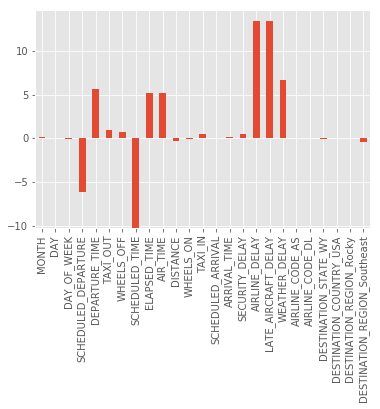

In [16]:
#Plot the coefficients
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(logreg.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

We see from our initial model that accuracy is already high. Let's take a closer look at some of the performance metrics of this model before we utilize grid search to improve the model, as well as our variables skewed heavily towards the delay indicators. We will proceed with evaluating model performance and then move towards improving results with GridSearch.

In [17]:
from sklearn import metrics as mt
conf = mt.confusion_matrix(y_test,yhat)
conf

array([[10394,    11],
       [  135,  1752]])

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test,yhat))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     10405
        1.0       0.99      0.93      0.96      1887

avg / total       0.99      0.99      0.99     12292



Both metrics, confusion matrix and classification report, show us that this is a high performing model. Recall is defined as
R = \frac{T_p}{T_p + F_n}.

We are interested in this metric in particular because we want to minimize our false negative rate because it is the most meaningful metric for this type of problem. Our business objective remains to create an accurate model with high accuracy and low false negatives to allow the flying public to project the flight status of their specific flight ahead of time. 

We finally see the trade off curve plotted below. Our results allow us to achieve both high precision and recall, a rare finding in an imbalanced data set. 

Average precision-recall score: 0.97


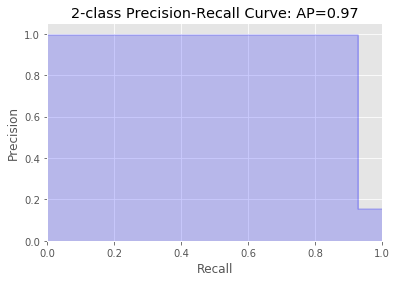

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, yhat)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test, yhat)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall Curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

#source: scikitlearn documentation

To recap, we performed variable selection and created a model based on the terms that were not penalized to 0 coefficients in L1 regularization.

<span style="color:blue; font-size:1.25em;">  Logistic Regression with Grid Search </span>

We saw that the model performed well based on an 80/20 train/test split. We will now investigate how to improve upon an already strong model using GridSearchCV. The variable we want to improve is C:"Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization" (scikit learn logistic regression documentation). 

In [20]:
#set up parameter grid search for C variable
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 2,10] }
logreg = LogisticRegression(C=0.01)
clf = GridSearchCV(logreg, param_grid)

#fit model
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 2, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
#print the best paramter of C found and best score
print(clf.best_score_)
print(clf.best_params_)

0.990766352099
{'C': 10}


We found the optimal parameter of C to be 10. It is not computationally efficient to find the true optimum of C. However, even with the modest score increase, we conclude this model is optimized. 

In [22]:
#print test accuracy using best estimator from gridsearch
grid_model = clf.best_estimator_
grid_model.fit(X_train_scaled, y_train)
grid_test = grid_model.predict(X_test_scaled)
print('Test accuracy: %.3f' % grid_model.score(X_test_scaled, y_test))

Test accuracy: 0.990


In [23]:
from sklearn import metrics as mt
#evaluate performance via confusion matrix
conf = mt.confusion_matrix(y_test,grid_test)
conf

array([[10393,    12],
       [  107,  1780]])

In [24]:
#take a look at the classification report
print(classification_report(y_test,grid_test))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     10405
        1.0       0.99      0.94      0.97      1887

avg / total       0.99      0.99      0.99     12292



We have very slightly improved our model performance, as both recall (0.93 to 0.94) and F1-score (0.96 to 0.97) have improved for our positive class of ARRIVAL DELAY = 1. While the practical effect of these improvements are negligible, we did want to illustrate the process. 

In [25]:
# sort these attributes and print out model coefficients
zip_vars = zip(grid_model.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_DEPARTURE has weight of -15.6376293587
SCHEDULED_TIME has weight of -14.1262176334
DESTINATION_REGION_Southeast has weight of -0.416966607106
WHEELS_ON has weight of -0.250758149992
DESTINATION_STATE_WY has weight of -0.141297535838
DAY_OF_WEEK has weight of -0.0670354755476
DAY has weight of -0.0355427369898
AIRLINE_CODE_AS has weight of -0.00406906400959
DESTINATION_COUNTRY_USA has weight of 0.0
DESTINATION_REGION_Rocky has weight of 0.00580242202218
SCHEDULED_ARRIVAL has weight of 0.0501630010851
DISTANCE has weight of 0.116552037941
MONTH has weight of 0.120419681637
AIRLINE_CODE_DL has weight of 0.128275084848
ARRIVAL_TIME has weight of 0.267633080374
WHEELS_OFF has weight of 0.290765206557
TAXI_IN has weight of 0.583315820434
SECURITY_DELAY has weight of 0.656314304846
TAXI_OUT has weight of 1.04543898936
ELAPSED_TIME has weight of 6.77475880094
AIR_TIME has weight of 6.80562115143
WEATHER_DELAY has weight of 15.3347102488
DEPARTURE_TIME has weight of 15.6756026708
AIRL

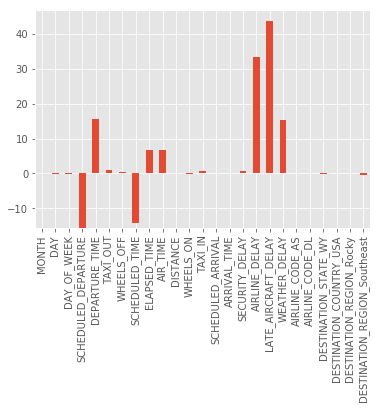

In [26]:
#Plot the coefficients
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(grid_model.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

<span style="color:green; font-size:1.5em;"> Model: Support Vector Machines </span>

We will now transition to modeling our data using a support vector machine classifier. We have a high benchmark to hit in terms of accuracy. However, we are also interested in evaluating the other pros and cons of each model, discussed in model advantages. For example, if we can achieve a more sparse model with comparable accuracy utilizing SVM, we will likely tend to pick that method, as it is assumed our audience will prefer a simple solution. 

<span style="color:blue; font-size:1.25em;">  SVM Variable Selection </span>

Just as with logistic regression, we begin with variable selection in order to reduce our massive data set to a more manageable size. 

In [20]:
# IMPORT ADDITIONAL MODULES FOR SVC AND GRAPHICS
from sklearn.feature_selection import SelectFromModel
import numpy as np
from matplotlib import style
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

In [21]:
print("The Shape of the data frame after adding dummy variables is", ATL1.shape)
#create an object to scale data using standard scaler
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

#scale X to make zero mean and unit standard deviation
scl_obj.fit(X) 
X_scaled = scl_obj.transform(X)

The Shape of the data frame after adding dummy variables is (61460, 395)


In [22]:
#Begin variable selection
SVC_1 = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X,y)
Model_1 = SelectFromModel(SVC_1, prefit=True)
X_new_1 = Model_1.transform(X)
X_new_1.shape

(61460, 25)

<span style="color:blue; font-size:1.25em;">  Inital SVM Model </span>

We notice that SVC picked approximately the same attributes for modeling. We continue with building our initial model.

In [23]:
#print out the features that were not zeroed out from the L1 regularization.
#These will be the features to use in the sparse data set. 
Model_1.get_support(indices=True)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  22, 364, 387, 391, 392], dtype=int64)

In [24]:
#make a new data frame of the selected 25 variables
ATL_trimmed = ATL1.ix[:,[0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18, 20, 22, 364, 387, 391, 392]]

Recall that we are assigning variable names from object ATL1. While the variable selection method picked feature 19, we must be careful. Feature 19 is ARRIVAL_IND in ATL1. Because of this, we take feature 20 from ATL1 since we need to 'ignore' feature 19, as it is our dependent variable. We see the features printed below and have assured that our list does not include ARRIVAL IND. 

In [25]:
ATL_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61460 entries, 38 to 931955
Data columns (total 25 columns):
MONTH                           61460 non-null int64
DAY                             61460 non-null int64
DAY_OF_WEEK                     61460 non-null int64
SCHEDULED_DEPARTURE             61460 non-null int64
DEPARTURE_TIME                  61460 non-null float64
TAXI_OUT                        61460 non-null float64
WHEELS_OFF                      61460 non-null float64
SCHEDULED_TIME                  61460 non-null float64
ELAPSED_TIME                    61460 non-null float64
AIR_TIME                        61460 non-null float64
DISTANCE                        61460 non-null int64
WHEELS_ON                       61460 non-null float64
TAXI_IN                         61460 non-null float64
SCHEDULED_ARRIVAL               61460 non-null int64
ARRIVAL_TIME                    61460 non-null float64
SECURITY_DELAY                  61460 non-null float64
AIRLINE_DELAY        

In [26]:
#X values assigned
X_trimmed_svc = ATL_trimmed.values

#assign a train/test split of 80/20, 80% allocated for training, 20% allocated for test. 
X_train_svc,X_test_svc,y_train_svc,y_test_svc = train_test_split(X_trimmed_svc,y,test_size=0.2, random_state = 42)

#create instace of SVC
SVC = LinearSVC()

#scale our X values
#scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train_svc) 

# find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data
X_train_scaled_svc = scl_obj.transform(X_train_svc) # apply to training
X_test_scaled_svc = scl_obj.transform(X_test_svc)

#fit model
SVC.fit(X_train_scaled_svc,y_train_svc)

#Predict on test data set
y_hat_svc = SVC.predict(X_test_scaled_svc)

print ("Score:", SVC.score(X_test_scaled_svc, y_test_svc))

Score: 0.988447770908


In [27]:
#generate confusion matrix for SVC model
svc_matrix= mt.confusion_matrix(y_test_svc,y_hat_svc)
print(svc_matrix)

[[10404     1]
 [  141  1746]]


In [28]:
#generate classification report
print(classification_report(y_test_svc, y_hat_svc))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     10405
        1.0       1.00      0.93      0.96      1887

avg / total       0.99      0.99      0.99     12292



In [29]:
# sort these attributes and print out model coefficients
zip_vars = zip(SVC.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_TIME has weight of -2.76323495907
SCHEDULED_DEPARTURE has weight of -2.37067308919
DESTINATION_REGION_Southeast has weight of -0.0920510642686
WHEELS_ON has weight of -0.0818371839752
DESTINATION_STATE_NH has weight of -0.0412927455211
DISTANCE has weight of -0.0291862302671
DAY_OF_WEEK has weight of -0.0184348612439
AIRLINE_CODE_AA has weight of -0.016148101973
DAY has weight of -0.00262380038457
DESTINATION_REGION_Rocky has weight of -0.001208473641
DESTINATION_COUNTRY_USA has weight of 0.0
WHEELS_OFF has weight of 0.0150898108052
MONTH has weight of 0.0242549728331
AIRLINE_CODE_DL has weight of 0.0269330045773
ARRIVAL_TIME has weight of 0.0417106235884
SCHEDULED_ARRIVAL has weight of 0.0687383886238
TAXI_IN has weight of 0.125141132271
SECURITY_DELAY has weight of 0.140276951867
TAXI_OUT has weight of 0.212734635968
ELAPSED_TIME has weight of 1.34936326583
AIR_TIME has weight of 1.35437038266
DEPARTURE_TIME has weight of 2.39562252899
WEATHER_DELAY has weight of 3.03185777

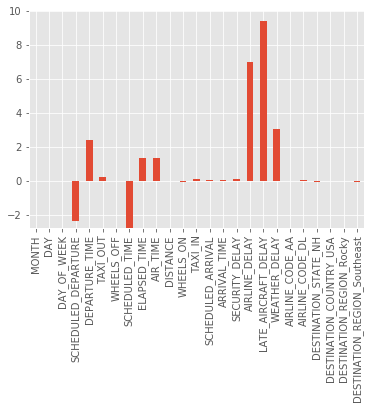

In [30]:
#Plot the coefficients
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(SVC.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

<span style="color:blue; font-size:1.25em;">  GridSearch SVM </span>

We will now investigate how to improve upon an already strong model using GridSearchCV. The variable we want to improve is C:"Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization" (scikit learn logistic regression documentation).

In [31]:
#set up parameter grid search for C variable
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
SVC  = LinearSVC()
clf_svc = GridSearchCV(SVC, param_grid)

#fit model
clf_svc.fit(X_train_scaled_svc,y_train_svc)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [32]:
#print the best paramter of C found and best score
print(clf_svc.best_score_)
print(clf_svc.best_params_)

0.98942401562
{'C': 10}


We do see a slight improvement over our initial SVM model from the best_score function. While this is not much of an increase, it does reinforce the importance of the chosen parameters. 

In [33]:
#print test accuracy using best estimator from gridsearch
grid_model_svc = clf_svc.best_estimator_
grid_model_svc.fit(X_train_scaled_svc, y_train_svc)
gridpredict = grid_model_svc.predict(X_test_scaled_svc)
print('Test accuracy: %.3f' % grid_model_svc.score(X_test_scaled_svc, y_test_svc))

Test accuracy: 0.988


In [34]:
#evaluate performance via confusion matrix
conf_gridsvm = mt.confusion_matrix(y_test_svc,gridpredict)
conf_gridsvm

array([[10398,     7],
       [  142,  1745]])

In [35]:
#take a look at the classification report
print(classification_report(y_test_svc, gridpredict))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     10405
        1.0       1.00      0.92      0.96      1887

avg / total       0.99      0.99      0.99     12292



In [36]:
# sort these attributes and print out model coefficients
zip_vars = zip(grid_model_svc.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_DEPARTURE has weight of -3.07422073501
SCHEDULED_TIME has weight of -2.8198307201
DESTINATION_STATE_NH has weight of -0.105859322628
WHEELS_ON has weight of -0.0890888310365
DESTINATION_REGION_Southeast has weight of -0.0784465678791
DISTANCE has weight of -0.059803707745
DAY has weight of -0.0258363908898
DESTINATION_COUNTRY_USA has weight of 0.0
DESTINATION_REGION_Rocky has weight of 0.00408146869814
DAY_OF_WEEK has weight of 0.015861483528
AIRLINE_CODE_DL has weight of 0.0317377726882
MONTH has weight of 0.0342164861311
ARRIVAL_TIME has weight of 0.0460373697418
AIRLINE_CODE_AA has weight of 0.059986069705
SCHEDULED_ARRIVAL has weight of 0.0947304017632
WHEELS_OFF has weight of 0.108173721675
TAXI_IN has weight of 0.123132971753
SECURITY_DELAY has weight of 0.144675055122
TAXI_OUT has weight of 0.195072308272
ELAPSED_TIME has weight of 1.38029135112
AIR_TIME has weight of 1.3883375145
DEPARTURE_TIME has weight of 2.99582891172
WEATHER_DELAY has weight of 3.74275611397
AIRL

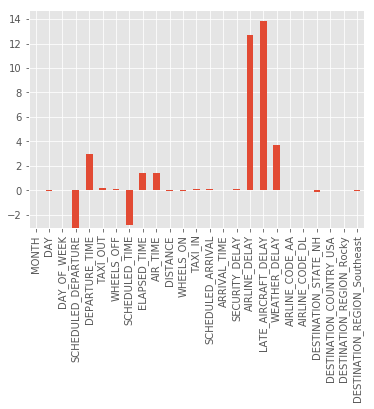

In [37]:
#Plot the coefficients
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(grid_model_svc.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

The SVM model with GridSearch CV represents a slight improvement over the initial model. Because we do not see an overwhelming imporvement, either initial SVM model or GridSearch model will be sufficient for deployment. 

## Model Advantages

One of the things most striking about this exercise was the very strong similarities amongst all the algorithms employed. Both of the logistic regression models and the support vector machines did exceedingly well. In the end though, there can be only one. In our case that one is the Grid Search Logistic Regression model. Our decision criteria were a combination of the test accuracy score, the precision, recall, and the F-Beta score. Test accuracy score shows the overall ability of the model to generalize and pick the correct category on previously unseen data. Precision is the ability of the model to not label an instance positive if it is actually a negative. Recall is how well the model correctly classifies positives. F-Beta is a measure of the balance of precision and recall, so it can be used to understand the ability of the model to both correctly classify positives and to **not** classify negatives as positives. The overall model performance is .99 with a recall of .94 and an F-Beta score of .9. For each family of models the training time wasn't signficantly different on our data set size. Differentation between the models is difficult for this data set, as both performed equivalently. We ultimately chose based on the slight perfomance advantage previously discussed. The comparative performance of the models can be seen below:

In [1]:
import pandas as pd
from collections import OrderedDict
data= OrderedDict([ ('Method', ['LogReg','GridLR','SVM','GridSVM']),
                  ('Accuracy', [0.99,0.99,0.988,0.988]),
                  ('Precision', [0.99,0.99,1.0,1.0]),
                  ('Recall', [0.93,0.94,0.93,0.92]),
                  ('F-Beta', [0.96,0.97,0.96,0.96]) ] )
df = pd.DataFrame.from_dict(data)
df

,Method,Accuracy,Precision,Recall,F-Beta
0,LogReg,0.990,0.99,0.93,0.96
1,GridLR,0.990,0.99,0.94,0.97
2,SVM,0.988,1.00,0.93,0.96
3,GridSVM,0.988,1.00,0.92,0.96


## Interpret Feature Importance
***

Since our variables have been standarized, we can now discuss the relative feature importance. We see that our model assigns the highest importance to the delay variables. Late Aircraft delay, airline dleay, and weather delay are our top three predictors of a significant late arrival when the origin airport is Atlanta. These coefficients are positive, meaning as these delays increase, so does the probability of one arriving late to his/her destination.The 6 features with the largest absolute value follow:  

* SCHEDULED_TIME has weight of -14.126217
* WEATHER_DELAY has weight of 15.334710
* SCHEDULED_DEPARTURE has weight of -15.637629
* DEPARTURE_TIME has weight of 15.675602
* AIRLINE_DELAY has weight of 33.553914
* LATE_AIRCRAFT_DELAY has weight of 43.839584

**SCHEDULED_TIME** has a negative weight, which means the scheduled time can be thought to improve the likelihood of being on time, rather than increasing the likelihood of a delay. Shorter flights tend to be more on time, especially from a major hub like Atlanta. Since a larger portion of the flights are to smaller airports with less traffic and fewer gate dependencies it follows these flights are less likely to encounter issues at the destination which would increase the likelihood of delay. 

**WEATHER_DELAY** is the first of the positive weighted features, with a relative contribution of 15.6. The impact of weather on lateness certainly is obvious. Our sample contains flights in November and December, where weather is potentially a problem, especially in relation to the LATE_AIRCRAFT_DELAY variable where weather in other parts of the country can impact our model. Perhaps the biggest surprise with the weather feature is that it is so low in the list of impacts on the model. Modern avionics and GPS make flying in inclement weather easier and more efficient, soomewhat mitigating the impact of weather. For many, this may be a counter-intuitive result as many of us think of weather being hugely impactful on flight times.

**SCHEDULED_DEPARTURE** is the second of our negatively weighted features. As discussed previously, the negative weight here actually means this feature increases the likelihood of being on time. This makes some intuitive sense, as the earlier in the day a flight begins, the less likely system or late aircraft delays have an opportunity to impact the flight. For the first flights of the day, the aircraft is already at the departure airport so there is a very small likelihood of a late aircraft delay, which is most impactful in the prediction of lateness.

**DEPARTURE TIME** is a positively weighted variable so it tends to increase the likelihood of delay in our model. Here we are able to use similar, but inverse logic to scheduled departure. The later in the day the departure, the more likely a flight is to be delayed on arrival. Air traffic and the dependent nature of moving equipment around the country lead to more delays the later in the day a flight departs. A five minute cumulative delay for an aircraft with 3 stops means the fourth arrival is going be at least 15 minutes late. As the day wears on, small delays for a variety of reasons tend to add up to a late flight. Intuitive, but somewhat reassuring our model has picked up on this. 

**AIRLINE_DELAY** is the second largest feature to impact the model. This feature is defined as "...The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.)" from https://www.rita.dot.gov/bts/help/aviation/index.html . This feature demonstrates that a significant amount of the delays could be controlled by the airline itself. Here we see, perhaps surprisingly, the airlines themselves cause significant numbers of delays. This feature seems to be one which should be most under control of the airlines themselves, but it continues to be more impactful than weather or time of day when determining lateness.

**LATE_AIRCRAFT_DELAY** has the heaviest impact on arrival delays. It should be obvious that if your aircraft is late in arriving from the previous flight, you are likely to be late in departing and thus late for the scheduled arrival for your flight. Here again we see an analogue between common sense and our model. This reinforces the idea of our model actually reflecting reality and providing some valuable sanity checks. Given the complexity of the airline system and the vagaries of weather, traffic, and other variables outside the scope of this document, this feature will continue to be very impactful.

## Interpret Support Vectors

<span style="color:blue; font-size:1.25em;">  Generate Support Vectors</span>


In [38]:
from sklearn.model_selection import ShuffleSplit

if 'ARRIVAL_IND' in X_trimmed_svc:
    y = X_trimmed_svc['ARRIVAL_IND'].values
    del X_trimmed_svc['ARRIVAL_IND'] 
    X = X_trimmed_svc.values
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [39]:
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]


X_train_scaled_svc = scl_obj.transform(X_train_svc)
X_test_scaled_svc = scl_obj.transform(X_test_svc)

In [40]:
#Get support vectors using linear kernel because model was constructed with linear SVC
from sklearn.svm import SVC
svm_clf = SVC(C=10, kernel='linear', degree = 3, gamma='auto')
svm_clf.fit(X_train_svc, y_train_svc)

In [41]:
#PRINT SUPPORT VECTORS
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(768, 25)
(768,)
[384 384]


In [55]:
#take a look at the support vectors
print(svm_clf.support_vectors_)

[[ 11.  12.   4. ...,   1.   1.   0.]
 [ 11.  18.   3. ...,   1.   0.   1.]
 [ 11.   6.   5. ...,   1.   0.   1.]
 ..., 
 [ 11.   1.   7. ...,   1.   0.   1.]
 [ 12.   7.   1. ...,   1.   0.   1.]
 [ 12.   1.   2. ...,   1.   0.   0.]]


In [58]:
#For simplicity, pull out the variables with high coefficients.

df= ATL1[['ARRIVAL_IND','SCHEDULED_TIME','SCHEDULED_DEPARTURE','ELAPSED_TIME',
'AIR_TIME','DEPARTURE_TIME']]

svm_test = df.iloc[train_indices]
svm_support = svm_test.iloc[svm_clf.support_,:]

svm_support['ARRIVAL_IND'] = y[svm_clf.support_]
svm_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 332226 to 926584
Data columns (total 6 columns):
ARRIVAL_IND            768 non-null float64
SCHEDULED_TIME         768 non-null float64
SCHEDULED_DEPARTURE    768 non-null int64
ELAPSED_TIME           768 non-null float64
AIR_TIME               768 non-null float64
DEPARTURE_TIME         768 non-null float64
dtypes: float64(5), int64(1)
memory usage: 42.0 KB


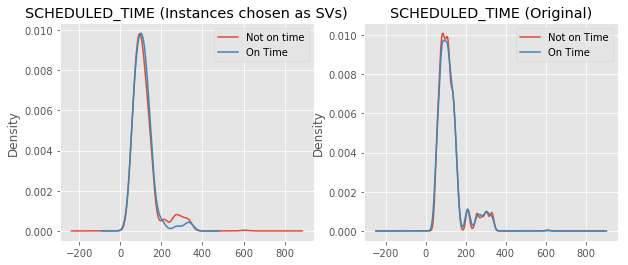

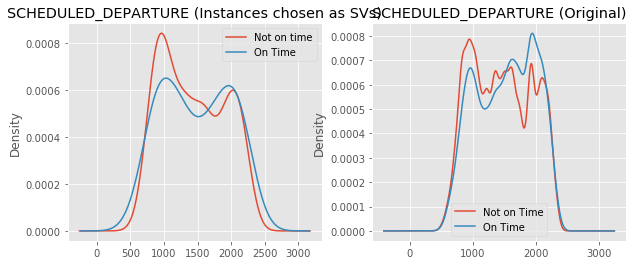

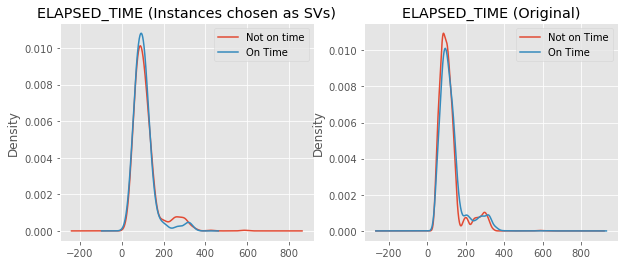

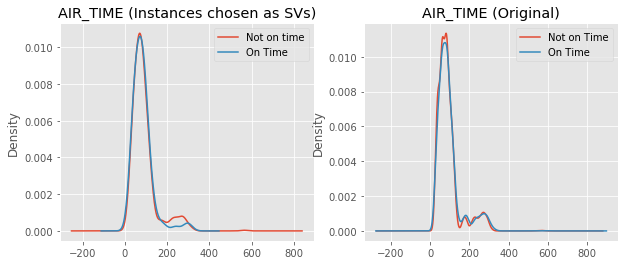

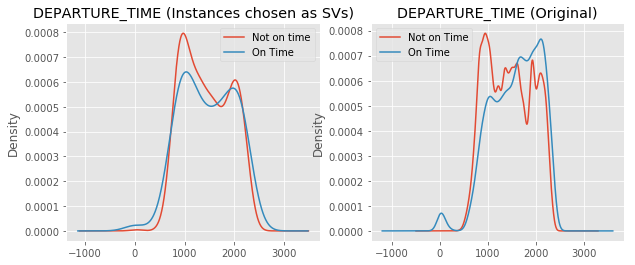

In [56]:
from pandas.tools.plotting import boxplot

df_grouped_support = svm_support.groupby(['ARRIVAL_IND'])
df_grouped = df.groupby(['ARRIVAL_IND'])

vars_to_plot = ['SCHEDULED_TIME','SCHEDULED_DEPARTURE','ELAPSED_TIME','AIR_TIME','DEPARTURE_TIME']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not on time','On Time'])
    plt.title(v+' (Instances chosen as SVs)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not on Time','On Time'])
    plt.title(v+' (Original)')

In regards to explaining support vectors, we begin with an analogy, "There is a social analogy that may help in understanding the notion of support vectors...During presidential elections, approximately 40% of the electorate votes for any Democratic candidate and approximately the same percentage votes for any Republican candidate (are explained by dedicated party members), independently of her or his platform. The result from elections depends on the 20% of undecided voters. These voters are the analogy of social support vectors" (Applying Computational Intelligence: How to Create Value, Dr. Arthur K. Kordon pg. 88)

Our analysis began with a run though the cross validation loop and setting the training/testing variable for a single iteration. We investigated the SVMs on the data and trained the model again. Next we looked at the shape of the support vectors and found specific instances that were selected as support vectors. We found 768 instances that form our support vectors. To help condense the number of variables to plot, we chose the following five for before/after comparisons:

- SCHEDULED_TIME (plotted)
- SCHEDULED_DEPARTURE (plotted)
- ELAPSED_TIME (plotted)
- AIR_TIME (plotted)
- DEPARTURE_TIME (plotted)

While these are not the features with the highest coefficients, we decided to ignore the 'obvious' predictors: all those that measure a 'delay' in security, weather, or airline related. The insight we gain from this approach is that the instances plotted by a time variable chosen as support vectors, show a considerable difference in before chosen and after. What this tells us, using the analogy above, is that the time features of this data set act as our 'independent voters.'

In each instance, we see that there is not much deviation from the original plot vs when the variable is chosen as a support vector. Looking closely at the plots of SCHEDULED_DEPARTURE and DEPARTURE_TIME, we can see that there is a visible difference between the relationships of flights that were on time vs. not on time in the original dataset. However, this gap is much closer when the instance is chosen as a support vector. This is due to the fact that the support vectors tend to be instances on the edge of the class boundaries as well as instances that are classfied incorrectly in the training data (paraphrased from eclarson github). 

These support vectors do provide insight into our data:

The support vectors for "scheduled time" were evenly distributed. Recall that scheduled time means the time allocated for the flight. The three highest timeframes were the 2-hour timeframe (6.9%), 18-hour timeframe (5.1%), and 5-hour timeframe (4.7%). The three lowest timeframes were the 24-hour timeframe (1.3%), 31-hour timeframe (1.3%), and 26-hour timeframe (1.6%).

The support vectors for "scheduled departure" were limited to the 11 o'clock and 12 o'clock departure times. 53% of the support vectors were from 11 o'clock while the remaining 47% were from 12 o'clock.